This notebook is to test the equivalence and the differences between the likelihood functions.

In [57]:
import pickle

data_file = "../data/data-v1.001.pkl"
with open (data_file, 'rb') as fin:
    idx, iidx, cascades, innovs = pickle.load (fin)

In [60]:
import numpy as np
import os
import sys
if not os.path.abspath ("../modules") in sys.path:
    sys.path.append (os.path.abspath ("../modules"))
import hpmodels
import hputils

bandwidth=1.0
dims=len(idx)

In [67]:
def log_likelihood_single_cascade (params,
                                   cascade,
                                   bandwidth=1.0,
                                   dims=5,
                                   sign=-1.0,
                                   epsilon=1e-5,
                                   verbose=False):
    # unflatten parameters
    mu = params[0*dims:1*dims]
    b = params[1*dims:2*dims]
    c = params[2*dims:3*dims]
    s = params[3*dims:4*dims]

    # initialization
    eta = np.zeros_like (mu)
    intensities = np.zeros_like (mu)
    total_intensities = np.zeros_like (mu)

    last_timestamp = -1
    log_intensities = 0
    se_gate = np.eye (dims)

    for timestamp in sorted(cascade.keys()):
        if last_timestamp < 0:
            eta = 0
        else:
            last_sources = cascade[last_timestamp]
            aggregator = np.zeros_like (mu)
            for last_source in last_sources:
                aggregator += ((b[last_source] * c) + (s*se_gate[last_source,:]))

            eta = hputils.exp_kernel (timestamp, last_timestamp, bandwidth) * (eta + aggregator)

        intensities = mu + eta
        current_sources = cascade[timestamp]
        log_intensities += np.log (intensities[current_sources] + epsilon).sum()
        total_intensities += intensities
        last_timestamp = timestamp

    ll = (sign) * (log_intensities - total_intensities.sum())
    return ll

def log_likelihood_many_cascades (params,
                                  cascades,
                                  single_cascade_likelihood,
                                  bandwidth=1.0,
                                  dims=5,
                                  sign=-1.0,
                                  epsilon=1e-5,
                                  verbose=False):
    n_cascades = len (cascades)
    total_log_likelihood = 0.0
    for i in range (n_cascades):
        log_likelihood = single_cascade_likelihood (params, \
                                                    cascades[i], \
                                                    bandwidth, \
                                                    dims, \
                                                    sign, \
                                                    epsilon, \
                                                    verbose)
        total_log_likelihood += log_likelihood

    if verbose: print (total_log_likelihood/n_cascades)
    return total_log_likelihood/n_cascades

def estimate_params (cascades,
                     multiple_cascades_log_likelihood,
                     single_cascade_log_likelihood,
                     log_optimizer=None,
                     gradient=None,
                     bandwidth=1.0,
                     dims=5,
                     seed=42):
    
    #initialize with a seed value so results can be replicated
    np.random.seed (seed)
    
    # set non-negativity bounds on the parameters
    bounds = [(0,None) for i in range (4*dims)]
    
    # random uniform initialization between 0 and 1
    params = np.random.uniform (0, 1, size=4*dims)
    
    # Multiply with -1 or 1 to minimize or maximize log likelihood respectively
    sign = -1.0
    
    # Small value for epsilon so we don't run into divide by zero errors
    epsilon = 1e-5
    
    result = minimize (multiple_cascades_log_likelihood,
                       params,
                       callback=log_optimizer, 
                       args=(cascades, single_cascade_log_likelihood, bandwidth, dims, sign, epsilon, False),
                       method='L-BFGS-B',
                       jac=gradient,
                       bounds=bounds,
                       options={'ftol': 1e-5, "maxls": 50, "maxcor":50, "maxiter":5000, "maxfun": 5000, "disp": True})
    return result

In [68]:
result = estimate_params (cascades[0:50], 
                          log_likelihood_many_cascades, 
                          log_likelihood_single_cascade,
                          bandwidth=bandwidth, 
                          dims=dims, 
                          seed=seed)

In [69]:
print (result)

      fun: -437.9228187196823
 hess_inv: <52x52 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.22403448e-02, -3.72608609e-02, -6.38181064e-02, -4.67082376e-02,
        2.65288237e-02,  1.51771928e-02, -4.92832441e-02, -7.27709449e-02,
        4.75168349e+00, -2.04465778e-02,  2.20361471e+00,  1.17609034e-02,
        1.09690859e+01,  4.02209821e+00,  5.06872766e-02, -3.47711193e-02,
        9.20981620e+00,  7.13839654e-02,  1.01863407e-01,  1.28125066e-02,
        1.60127911e-02,  7.47166951e-01, -6.75299820e-03,  1.45905688e-01,
        2.68471466e-02,  1.55239377e-02,  4.15354862e-02,  2.62957656e-02,
        1.36765266e-02,  1.44694922e-01, -3.18323148e-03, -3.02691207e-02,
        1.98781436e-02,  2.54487986e-02, -1.72690307e-02,  8.42419468e-03,
       -4.47357704e-03,  1.29057298e-01,  5.52972779e-02, -3.20937941e-02,
       -5.04201123e-03, -1.11128883e-02,  9.77494778e+00,  1.04705578e-02,
        5.47402121e-02,  5.97179906e-01,  1.77806214e-02,  1.40549332e+00,
 

In [31]:
import numpy as np
from scipy.optimize import minimize

# initialize
seed = 42
np.random.seed (seed)
params = np.random.uniform (0, 1, size=4*dims)

# set bounds
bounds = [(0,None) for i in range (4*dims)] # set the non-negativity bounds on the parameters

# Before running the optimizer, evaluate the objective with
# 

def estimate_discrete_coarse_params (cascades,
                                     log_likelihood,
                                     log_optimizer,
                                     gradient=None,
                                     bandwidth=1.0,
                                     dims=5,
                                     seed=42):
    np.random.seed (seed)
    bounds = [(0,None) for i in range (4*dims)] # set the non-negativity bounds on the parameters
    params = np.random.uniform (0, 1, size=4*dims) # random initialization of the parameters
    sign = -1.0 # Multiply so that we can minimize negative log likelihood
    epsilon = 1e-5
    result = minimize (log_likelihood,
                       params,
                       callback=log_optimizer, 
                       args=(cascades, bandwidth, dims, sign, epsilon, False),
                       method='L-BFGS-B',
                       jac=gradient,
                       bounds=bounds,
                       options={'ftol': 1e-5, "maxls": 50, "maxcor":50, "maxiter":5000, "maxfun": 5000, "disp": True})

    return result

In [33]:
results = list ()
for seed in [1, 10, 100]:
    result = estimate_discrete_coarse_params (cascades[0:10], hpmodels.DCHP.log_likelihood_many_cascades, bandwidth=bandwidth, dims=dims, seed=seed)
    results.append (result)
    
#mu = result.x[0*dims:1*dims]
#b = result.x[1*dims:2*dims]
#c = result.x[2*dims:3*dims]
#s = result.x[3*dims:4*dims]

In [54]:
import pickle
with open ("temp.pkl", "wb") as fout:
    pickle.dump(result, fout)

In [55]:
import pickle
with open ("temp.pkl", "rb") as fin:
    res = pickle.load (fin)

In [36]:
for result in results:
    print (result.fun)

-409.3539280864108
-409.35519621547377
-409.36478701778725


The likelihoods are very similar. It means that different initializations at least converge to a local minima. However, do different parameters lead to the same objective?

<BarContainer object of 13 artists>

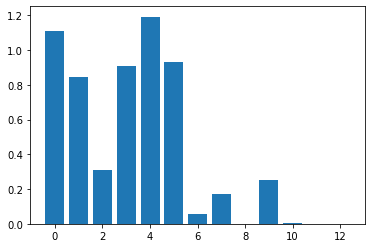

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar (list (range (dims)), results[0].x[0*dims:1*dims])

In [43]:
print(np.linalg.norm(results[0].x[0*dims:1*dims] - results[1].x[0*dims:1*dims]))
print(np.linalg.norm(results[0].x[1*dims:2*dims] - results[1].x[1*dims:2*dims]))
print(np.linalg.norm(results[0].x[2*dims:3*dims] - results[1].x[2*dims:3*dims]))
print(np.linalg.norm(results[0].x[3*dims:4*dims] - results[1].x[3*dims:4*dims]))

0.040894092936725815
0.7930474415337577
0.7887388851585643
1.2611529485133222


In [44]:
results[0].x[1*dims: 2*dims]

array([0.        , 0.01326876, 0.2361898 , 0.        , 0.1242115 ,
       0.34186547, 0.22672149, 0.29685991, 0.        , 2.14653415,
       0.08946789, 0.86385549, 0.88047674])

In [6]:
mu = np.random.rand (5)
print (mu)

[0.51107148 0.21681343 0.6348066  0.19109664 0.64933803]


In [8]:


mu = np.random.rand (dims)
b = np.random.rand (dims)
c = np.random.rand (dims)
s = np.random.rand (dims)
params = np.concatenate ((mu, b, c, s))

In [10]:
current_implementation_log_likelihood = hpmodels.DCHP.log_likelihood_many_cascades (params, cascades, bandwidth=bandwidth, dims=dims, sign=1.0)
print (current_implementation_log_likelihood)

63.96312798142929


In [ ]:
def log_likelihood_single_cascade (params,
                                   cascade,
                                   bandwidth=1.0,
                                   dims=5,
                                   sign=-1.0,
                                   epsilon=1e-5,
                                   verbose=False):
        # unflatten parameters
        mu = params[0*dims:1*dims]
        b = params[1*dims:2*dims]
        c = params[2*dims:3*dims]
        s = params[3*dims:4*dims]
        
        pass

def log_likelihood_many_cascades (params,
                                  cascades,
                                  bandwidth=1.0,
                                  dims=5,
                                  sign=-1.0,
                                  epsilon=1e-5,
                                  verbose=False):
    
    n_cascades = len (cascades)
    total_log_likelihood = 0.0
    for i in range (n_cascades):
        log_likelihood = log_likelihood_single_cascade (params, \
                                                        cascades[i], \
                                                        bandwidth, \
                                                        dims, \
                                                        sign, \
                                                        epsilon, \
                                                        verbose)

        total_log_likelihood += log_likelihood

    if verbose: print (total_log_likelihood/n_cascades)
    return total_log_likelihood/n_cascades

In [71]:
l = [1,2,3,4,5,6,7,8,9,10]
l[0:None]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]